In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

from tqdm.auto import tqdm

In [2]:
DATASET = "mnist" # 'cifar10 | lsun | mnist |imagenet | folder | lfw | fake'
DATAROOT = ""
outf = "./dcgan" # folder to output images and model checkpoints
WORKERS = 2
BS = 64
IMG_SIZE = 64
EPOCHS = 25

nz = 100 # size of the latent z vector
ngf = 64
ndf = 64

lr = 0.0002
beta1 = 0.5

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")
ngpu = 1

try:
    os.makedirs(outf)
except OSError:
    pass

manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

device: cuda
Random Seed:  2689


In [3]:
if DATAROOT is None and str(DATASET).lower() != 'fake':
    raise ValueError("`dataroot` parameter is required for dataset \"%s\"" % DATASET)

if DATASET == 'mnist':
    dataset = dset.MNIST(root=DATAROOT, download=True,
                       transform=transforms.Compose([
                           transforms.Resize(IMG_SIZE),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))
    nc=1
elif DATASET == 'cifar10':
    dataset = dset.CIFAR10(root=DATAROOT, download=True,
                           transform=transforms.Compose([
                               transforms.Resize(IMG_SIZE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
    nc=3
else:
    raise AssertionError(f"Not implemented dataset: {DATASET}!")
assert dataset

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BS,
                                         shuffle=True, num_workers=WORKERS)

In [4]:
# custom weights initialization for netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)


'''
Generator

input: z (nz)
output: fake image (nc, IMG_SIZE, IMG_SIZE)
'''
class Generator(nn.Module):
    def __init__(self, nz, ngf):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, inputs):
        output = self.main(inputs)
        return output


netG = Generator(nz, ngf).to(device)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [5]:
'''
Discriminator

input: image (nc, IMG_SIZE, IMG_SIZE)
output: 0~1 fake or real probability of images
'''
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        output = self.main(inputs)
        return output.view(-1, 1).squeeze(1)


netD = Discriminator(nc, ndf).to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [18]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(BS, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

for epoch in tqdm(range(EPOCHS)):
    for i, data in enumerate(tqdm(dataloader, leave=False), 0):
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        
        # train with real images
        netD.zero_grad()
        real_imgs = data[0].to(device)
        batch_size = real_imgs.size(0)
        # generate a batch of real labels
        label = torch.full((batch_size,), real_label,
                           dtype=real_imgs.dtype, device=device)
        
        output = netD(real_imgs)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake images
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        # generate fake images
        fake = netG(noise)
        label.fill_(fake_label)
        # use D to predict fake images
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        optimizerD.step()

        # (2) Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, EPOCHS, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            vutils.save_image(real_imgs,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)

    # save checkpoint
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

[0/25][0/938] Loss_D: 0.1874 Loss_G: 7.3824 D(x): 0.9278 D(G(z)): 0.0910 / 0.0017
[0/25][100/938] Loss_D: 0.1248 Loss_G: 4.4520 D(x): 0.9198 D(G(z)): 0.0290 / 0.0173
[0/25][200/938] Loss_D: 0.5474 Loss_G: 2.2812 D(x): 0.6554 D(G(z)): 0.0220 / 0.1500
[0/25][300/938] Loss_D: 0.0573 Loss_G: 4.8877 D(x): 0.9575 D(G(z)): 0.0125 / 0.0133
[0/25][400/938] Loss_D: 1.0803 Loss_G: 0.6335 D(x): 0.4402 D(G(z)): 0.0550 / 0.5937
[0/25][500/938] Loss_D: 0.4325 Loss_G: 3.4657 D(x): 0.9411 D(G(z)): 0.2812 / 0.0407
[0/25][600/938] Loss_D: 0.0641 Loss_G: 4.4855 D(x): 0.9679 D(G(z)): 0.0294 / 0.0186
[0/25][700/938] Loss_D: 0.2797 Loss_G: 2.5574 D(x): 0.8391 D(G(z)): 0.0842 / 0.1066
[0/25][800/938] Loss_D: 0.2398 Loss_G: 1.8216 D(x): 0.8114 D(G(z)): 0.0141 / 0.2339
[0/25][900/938] Loss_D: 0.2133 Loss_G: 2.7277 D(x): 0.8449 D(G(z)): 0.0323 / 0.0989


  0%|          | 0/938 [00:00<?, ?it/s]

[1/25][0/938] Loss_D: 0.2967 Loss_G: 3.4160 D(x): 0.8035 D(G(z)): 0.0472 / 0.0612
[1/25][100/938] Loss_D: 0.3287 Loss_G: 2.4230 D(x): 0.7811 D(G(z)): 0.0383 / 0.1215
[1/25][200/938] Loss_D: 0.0266 Loss_G: 4.5445 D(x): 0.9947 D(G(z)): 0.0208 / 0.0149
[1/25][300/938] Loss_D: 0.3312 Loss_G: 3.3129 D(x): 0.8218 D(G(z)): 0.0906 / 0.0648
[1/25][400/938] Loss_D: 0.1110 Loss_G: 3.9520 D(x): 0.9590 D(G(z)): 0.0609 / 0.0299
[1/25][500/938] Loss_D: 0.0808 Loss_G: 4.0566 D(x): 0.9486 D(G(z)): 0.0254 / 0.0264
[1/25][600/938] Loss_D: 0.9001 Loss_G: 1.1847 D(x): 0.7204 D(G(z)): 0.3052 / 0.3689
[1/25][700/938] Loss_D: 0.4570 Loss_G: 2.6635 D(x): 0.8655 D(G(z)): 0.2192 / 0.1140
[1/25][800/938] Loss_D: 0.0888 Loss_G: 4.3016 D(x): 0.9743 D(G(z)): 0.0525 / 0.0197
[1/25][900/938] Loss_D: 0.6200 Loss_G: 1.8820 D(x): 0.6336 D(G(z)): 0.0600 / 0.2012


  0%|          | 0/938 [00:00<?, ?it/s]

[2/25][0/938] Loss_D: 0.1846 Loss_G: 4.8945 D(x): 0.9828 D(G(z)): 0.1452 / 0.0107
[2/25][100/938] Loss_D: 0.3827 Loss_G: 2.8456 D(x): 0.7221 D(G(z)): 0.0145 / 0.0880
[2/25][200/938] Loss_D: 0.3669 Loss_G: 6.5143 D(x): 0.9892 D(G(z)): 0.2618 / 0.0021
[2/25][300/938] Loss_D: 0.7486 Loss_G: 2.6150 D(x): 0.8030 D(G(z)): 0.3662 / 0.0966
[2/25][400/938] Loss_D: 0.0514 Loss_G: 5.0566 D(x): 0.9748 D(G(z)): 0.0247 / 0.0116
[2/25][500/938] Loss_D: 0.0325 Loss_G: 5.1051 D(x): 0.9782 D(G(z)): 0.0102 / 0.0084
[2/25][600/938] Loss_D: 0.2144 Loss_G: 4.8119 D(x): 0.9817 D(G(z)): 0.1458 / 0.0153
[2/25][700/938] Loss_D: 0.8689 Loss_G: 1.2895 D(x): 0.5850 D(G(z)): 0.1728 / 0.3569
[2/25][800/938] Loss_D: 0.1191 Loss_G: 4.0955 D(x): 0.9205 D(G(z)): 0.0305 / 0.0247
[2/25][900/938] Loss_D: 0.0609 Loss_G: 4.0364 D(x): 0.9687 D(G(z)): 0.0273 / 0.0234


  0%|          | 0/938 [00:00<?, ?it/s]

[3/25][0/938] Loss_D: 0.4678 Loss_G: 2.8724 D(x): 0.9525 D(G(z)): 0.2999 / 0.0808
[3/25][100/938] Loss_D: 0.5123 Loss_G: 1.8822 D(x): 0.7187 D(G(z)): 0.1199 / 0.1955
[3/25][200/938] Loss_D: 0.0424 Loss_G: 4.7020 D(x): 0.9692 D(G(z)): 0.0102 / 0.0136
[3/25][300/938] Loss_D: 0.4112 Loss_G: 0.5541 D(x): 0.7019 D(G(z)): 0.0148 / 0.6271
[3/25][400/938] Loss_D: 0.1741 Loss_G: 3.2338 D(x): 0.9011 D(G(z)): 0.0574 / 0.0647
[3/25][500/938] Loss_D: 0.1402 Loss_G: 3.1392 D(x): 0.9018 D(G(z)): 0.0259 / 0.0613
[3/25][600/938] Loss_D: 0.0291 Loss_G: 4.7908 D(x): 0.9872 D(G(z)): 0.0158 / 0.0126
[3/25][700/938] Loss_D: 0.0366 Loss_G: 4.9906 D(x): 0.9914 D(G(z)): 0.0271 / 0.0104
[3/25][800/938] Loss_D: 1.0068 Loss_G: 1.6413 D(x): 0.6122 D(G(z)): 0.3319 / 0.2374
[3/25][900/938] Loss_D: 0.3748 Loss_G: 3.8419 D(x): 0.9753 D(G(z)): 0.2611 / 0.0284


  0%|          | 0/938 [00:00<?, ?it/s]

[4/25][0/938] Loss_D: 0.2186 Loss_G: 3.4065 D(x): 0.8527 D(G(z)): 0.0356 / 0.0575
[4/25][100/938] Loss_D: 0.9817 Loss_G: 1.6015 D(x): 0.6416 D(G(z)): 0.3546 / 0.2420
[4/25][200/938] Loss_D: 0.2987 Loss_G: 3.1362 D(x): 0.7847 D(G(z)): 0.0270 / 0.0614
[4/25][300/938] Loss_D: 0.2276 Loss_G: 5.3467 D(x): 0.9882 D(G(z)): 0.1792 / 0.0063
[4/25][400/938] Loss_D: 1.2168 Loss_G: 5.4521 D(x): 0.9239 D(G(z)): 0.5968 / 0.0082
[4/25][500/938] Loss_D: 0.1065 Loss_G: 4.1637 D(x): 0.9145 D(G(z)): 0.0118 / 0.0244
[4/25][600/938] Loss_D: 0.1350 Loss_G: 3.3826 D(x): 0.9145 D(G(z)): 0.0335 / 0.0548
[4/25][700/938] Loss_D: 0.2375 Loss_G: 2.8420 D(x): 0.8168 D(G(z)): 0.0145 / 0.0862
[4/25][800/938] Loss_D: 0.0403 Loss_G: 4.6841 D(x): 0.9797 D(G(z)): 0.0179 / 0.0167
[4/25][900/938] Loss_D: 0.6991 Loss_G: 2.1831 D(x): 0.8317 D(G(z)): 0.3411 / 0.1583


  0%|          | 0/938 [00:00<?, ?it/s]

[5/25][0/938] Loss_D: 0.3406 Loss_G: 2.7056 D(x): 0.8059 D(G(z)): 0.0953 / 0.0994
[5/25][100/938] Loss_D: 0.0913 Loss_G: 4.0820 D(x): 0.9405 D(G(z)): 0.0264 / 0.0277
[5/25][200/938] Loss_D: 0.3728 Loss_G: 2.6755 D(x): 0.8045 D(G(z)): 0.1110 / 0.1031
[5/25][300/938] Loss_D: 0.0461 Loss_G: 4.3010 D(x): 0.9758 D(G(z)): 0.0202 / 0.0216
[5/25][400/938] Loss_D: 0.1827 Loss_G: 2.2789 D(x): 0.8658 D(G(z)): 0.0272 / 0.1522
[5/25][500/938] Loss_D: 0.1099 Loss_G: 3.8758 D(x): 0.9253 D(G(z)): 0.0276 / 0.0284
[5/25][600/938] Loss_D: 0.0304 Loss_G: 5.2192 D(x): 0.9856 D(G(z)): 0.0153 / 0.0091
[5/25][700/938] Loss_D: 0.0447 Loss_G: 4.4427 D(x): 0.9781 D(G(z)): 0.0218 / 0.0176
[5/25][800/938] Loss_D: 1.1418 Loss_G: 0.8886 D(x): 0.5540 D(G(z)): 0.3679 / 0.4492
[5/25][900/938] Loss_D: 0.5377 Loss_G: 2.9110 D(x): 0.8385 D(G(z)): 0.2502 / 0.0810


  0%|          | 0/938 [00:00<?, ?it/s]

[6/25][0/938] Loss_D: 2.4176 Loss_G: 1.2159 D(x): 0.1617 D(G(z)): 0.0330 / 0.4549
[6/25][100/938] Loss_D: 0.6164 Loss_G: 4.5378 D(x): 0.9293 D(G(z)): 0.3381 / 0.0179
[6/25][200/938] Loss_D: 0.2378 Loss_G: 3.0702 D(x): 0.8285 D(G(z)): 0.0329 / 0.0693
[6/25][300/938] Loss_D: 0.0265 Loss_G: 5.0738 D(x): 0.9811 D(G(z)): 0.0072 / 0.0094
[6/25][400/938] Loss_D: 0.9172 Loss_G: 8.7689 D(x): 0.9693 D(G(z)): 0.5091 / 0.0002
[6/25][500/938] Loss_D: 1.9755 Loss_G: 4.3159 D(x): 0.9200 D(G(z)): 0.7562 / 0.0219
[6/25][600/938] Loss_D: 0.0375 Loss_G: 4.3719 D(x): 0.9752 D(G(z)): 0.0118 / 0.0180
[6/25][700/938] Loss_D: 0.0394 Loss_G: 4.7655 D(x): 0.9733 D(G(z)): 0.0110 / 0.0169
[6/25][800/938] Loss_D: 0.1899 Loss_G: 2.9968 D(x): 0.8870 D(G(z)): 0.0583 / 0.0717
[6/25][900/938] Loss_D: 0.0867 Loss_G: 4.9472 D(x): 0.9768 D(G(z)): 0.0589 / 0.0117


  0%|          | 0/938 [00:00<?, ?it/s]

[7/25][0/938] Loss_D: 0.0626 Loss_G: 4.6605 D(x): 0.9790 D(G(z)): 0.0389 / 0.0142
[7/25][100/938] Loss_D: 0.0295 Loss_G: 4.7854 D(x): 0.9883 D(G(z)): 0.0174 / 0.0143
[7/25][200/938] Loss_D: 0.8722 Loss_G: 1.8959 D(x): 0.6991 D(G(z)): 0.3318 / 0.1858
[7/25][300/938] Loss_D: 0.3079 Loss_G: 3.2403 D(x): 0.9228 D(G(z)): 0.1859 / 0.0507
[7/25][400/938] Loss_D: 0.6706 Loss_G: 5.1057 D(x): 0.9418 D(G(z)): 0.3768 / 0.0088
[7/25][500/938] Loss_D: 0.2687 Loss_G: 2.8106 D(x): 0.8747 D(G(z)): 0.1101 / 0.0866
[7/25][600/938] Loss_D: 0.0982 Loss_G: 4.6640 D(x): 0.9860 D(G(z)): 0.0706 / 0.0145
[7/25][700/938] Loss_D: 0.0454 Loss_G: 4.7864 D(x): 0.9803 D(G(z)): 0.0244 / 0.0145
[7/25][800/938] Loss_D: 0.8443 Loss_G: 1.2999 D(x): 0.6237 D(G(z)): 0.2597 / 0.3035
[7/25][900/938] Loss_D: 0.8244 Loss_G: 2.7545 D(x): 0.5333 D(G(z)): 0.0468 / 0.1250


  0%|          | 0/938 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ec2779cb0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1480, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1463, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ec2779cb0>

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1480, in __del__

AssertionError    : self._shutdown_workers()can only test a child process

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1463, in _shutdown_workers
    if w.is_alive():
Exception ignore

[8/25][0/938] Loss_D: 0.3772 Loss_G: 2.8490 D(x): 0.8288 D(G(z)): 0.1290 / 0.0832
[8/25][100/938] Loss_D: 0.0423 Loss_G: 4.3671 D(x): 0.9814 D(G(z)): 0.0227 / 0.0214
[8/25][200/938] Loss_D: 0.1534 Loss_G: 4.4958 D(x): 0.9438 D(G(z)): 0.0713 / 0.0183
[8/25][300/938] Loss_D: 0.0299 Loss_G: 4.8658 D(x): 0.9845 D(G(z)): 0.0137 / 0.0121
[8/25][400/938] Loss_D: 1.0412 Loss_G: 1.7889 D(x): 0.7462 D(G(z)): 0.4484 / 0.2132
[8/25][500/938] Loss_D: 1.5198 Loss_G: 1.7409 D(x): 0.8066 D(G(z)): 0.6311 / 0.2246
[8/25][600/938] Loss_D: 0.0568 Loss_G: 5.4106 D(x): 0.9892 D(G(z)): 0.0438 / 0.0064
[8/25][700/938] Loss_D: 0.0498 Loss_G: 4.3796 D(x): 0.9659 D(G(z)): 0.0140 / 0.0180
[8/25][800/938] Loss_D: 0.0159 Loss_G: 5.6101 D(x): 0.9980 D(G(z)): 0.0136 / 0.0059
[8/25][900/938] Loss_D: 0.5384 Loss_G: 1.5305 D(x): 0.7891 D(G(z)): 0.2302 / 0.2641


  0%|          | 0/938 [00:00<?, ?it/s]

[9/25][0/938] Loss_D: 0.3822 Loss_G: 2.5556 D(x): 0.8808 D(G(z)): 0.1946 / 0.1008
[9/25][100/938] Loss_D: 0.3148 Loss_G: 3.7871 D(x): 0.9147 D(G(z)): 0.1832 / 0.0300
[9/25][200/938] Loss_D: 0.1040 Loss_G: 2.6594 D(x): 0.9113 D(G(z)): 0.0061 / 0.0948
[9/25][300/938] Loss_D: 0.0178 Loss_G: 5.5984 D(x): 0.9927 D(G(z)): 0.0102 / 0.0062
[9/25][400/938] Loss_D: 1.6951 Loss_G: 2.0526 D(x): 0.2707 D(G(z)): 0.0078 / 0.1849
[9/25][500/938] Loss_D: 0.8399 Loss_G: 1.2918 D(x): 0.5131 D(G(z)): 0.0021 / 0.3862
[9/25][600/938] Loss_D: 0.0225 Loss_G: 5.0091 D(x): 0.9913 D(G(z)): 0.0134 / 0.0095
[9/25][700/938] Loss_D: 0.7172 Loss_G: 2.1415 D(x): 0.6579 D(G(z)): 0.1806 / 0.1744
[9/25][800/938] Loss_D: 0.2022 Loss_G: 2.3170 D(x): 0.8392 D(G(z)): 0.0104 / 0.1638
[9/25][900/938] Loss_D: 0.0490 Loss_G: 4.7251 D(x): 0.9933 D(G(z)): 0.0388 / 0.0139


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ec2779cb0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1480, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1463, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ec2779cb0>assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):
AssertionError  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1480, in __del__
:     can only test a child processself._shutdown_workers()

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1463, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

  0%|          | 0/938 [00:00<?, ?it/s]

[10/25][0/938] Loss_D: 0.0246 Loss_G: 4.9990 D(x): 0.9863 D(G(z)): 0.0107 / 0.0105
[10/25][100/938] Loss_D: 0.0090 Loss_G: 6.0955 D(x): 0.9972 D(G(z)): 0.0062 / 0.0042
[10/25][200/938] Loss_D: 0.0365 Loss_G: 6.6975 D(x): 0.9953 D(G(z)): 0.0305 / 0.0021
[10/25][300/938] Loss_D: 0.0139 Loss_G: 6.7655 D(x): 0.9994 D(G(z)): 0.0131 / 0.0020
[10/25][400/938] Loss_D: 0.0059 Loss_G: 6.7426 D(x): 0.9996 D(G(z)): 0.0055 / 0.0021
[10/25][500/938] Loss_D: 0.0048 Loss_G: 6.7466 D(x): 0.9999 D(G(z)): 0.0047 / 0.0021
[10/25][600/938] Loss_D: 0.0031 Loss_G: 6.8819 D(x): 0.9996 D(G(z)): 0.0027 / 0.0013
[10/25][700/938] Loss_D: 0.0006 Loss_G: 10.1104 D(x): 0.9995 D(G(z)): 0.0001 / 0.0001
[10/25][800/938] Loss_D: 0.0011 Loss_G: 7.9341 D(x): 0.9999 D(G(z)): 0.0010 / 0.0005
[10/25][900/938] Loss_D: 0.0007 Loss_G: 8.4159 D(x): 0.9998 D(G(z)): 0.0005 / 0.0003


  0%|          | 0/938 [00:00<?, ?it/s]

[11/25][0/938] Loss_D: 0.0002 Loss_G: 9.5557 D(x): 0.9999 D(G(z)): 0.0001 / 0.0001
[11/25][100/938] Loss_D: 0.0007 Loss_G: 8.6268 D(x): 0.9997 D(G(z)): 0.0005 / 0.0003
[11/25][200/938] Loss_D: 0.0004 Loss_G: 8.6390 D(x): 0.9999 D(G(z)): 0.0003 / 0.0003
[11/25][300/938] Loss_D: 0.0003 Loss_G: 8.4718 D(x): 1.0000 D(G(z)): 0.0003 / 0.0002
[11/25][400/938] Loss_D: 0.0006 Loss_G: 8.3072 D(x): 0.9998 D(G(z)): 0.0004 / 0.0003
[11/25][500/938] Loss_D: 0.0019 Loss_G: 7.3755 D(x): 0.9999 D(G(z)): 0.0018 / 0.0006
[11/25][600/938] Loss_D: 0.0009 Loss_G: 7.6134 D(x): 0.9996 D(G(z)): 0.0005 / 0.0005
[11/25][700/938] Loss_D: 0.0009 Loss_G: 8.9971 D(x): 0.9997 D(G(z)): 0.0007 / 0.0001
[11/25][800/938] Loss_D: 0.0004 Loss_G: 8.5923 D(x): 0.9999 D(G(z)): 0.0003 / 0.0002
[11/25][900/938] Loss_D: 0.0362 Loss_G: 11.5522 D(x): 0.9816 D(G(z)): 0.0000 / 0.0000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ec2779cb0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1480, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1463, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ec2779cb0>

  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1480, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'
    AssertionErrorself._shutdown_workers(): 
can only test a child process  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1463, in _shutdown_workers

    if w.is_alive():
  File "/opt/con

  0%|          | 0/938 [00:00<?, ?it/s]

[12/25][0/938] Loss_D: 0.2729 Loss_G: 17.0949 D(x): 1.0000 D(G(z)): 0.2378 / 0.0000
[12/25][100/938] Loss_D: 0.0023 Loss_G: 18.8784 D(x): 0.9978 D(G(z)): 0.0000 / 0.0000
[12/25][200/938] Loss_D: 0.1867 Loss_G: 4.9155 D(x): 0.9310 D(G(z)): 0.0623 / 0.0125
[12/25][300/938] Loss_D: 0.1758 Loss_G: 4.6738 D(x): 0.8837 D(G(z)): 0.0017 / 0.0195
[12/25][400/938] Loss_D: 0.0371 Loss_G: 4.8932 D(x): 0.9881 D(G(z)): 0.0234 / 0.0116
[12/25][500/938] Loss_D: 0.0158 Loss_G: 7.8497 D(x): 0.9988 D(G(z)): 0.0144 / 0.0007
[12/25][600/938] Loss_D: 0.0036 Loss_G: 7.3439 D(x): 0.9993 D(G(z)): 0.0029 / 0.0009
[12/25][700/938] Loss_D: 0.0007 Loss_G: 8.5553 D(x): 0.9997 D(G(z)): 0.0003 / 0.0002
[12/25][800/938] Loss_D: 0.0015 Loss_G: 7.5635 D(x): 0.9995 D(G(z)): 0.0010 / 0.0006
[12/25][900/938] Loss_D: 0.0058 Loss_G: 7.4231 D(x): 0.9965 D(G(z)): 0.0022 / 0.0007


  0%|          | 0/938 [00:00<?, ?it/s]

[13/25][0/938] Loss_D: 0.0091 Loss_G: 6.6775 D(x): 0.9938 D(G(z)): 0.0025 / 0.0013
[13/25][100/938] Loss_D: 0.0000 Loss_G: 9.6023 D(x): 1.0000 D(G(z)): 0.0000 / 0.0001
[13/25][200/938] Loss_D: 0.0033 Loss_G: 7.7441 D(x): 0.9995 D(G(z)): 0.0029 / 0.0004
[13/25][300/938] Loss_D: 0.0209 Loss_G: 4.8214 D(x): 0.9971 D(G(z)): 0.0177 / 0.0087
[13/25][400/938] Loss_D: 0.0207 Loss_G: 6.2676 D(x): 0.9898 D(G(z)): 0.0097 / 0.0020
[13/25][500/938] Loss_D: 0.0125 Loss_G: 6.3485 D(x): 0.9990 D(G(z)): 0.0114 / 0.0022
[13/25][600/938] Loss_D: 0.0224 Loss_G: 6.3470 D(x): 0.9864 D(G(z)): 0.0056 / 0.0019
[13/25][700/938] Loss_D: 0.0189 Loss_G: 5.7465 D(x): 0.9945 D(G(z)): 0.0132 / 0.0035
[13/25][800/938] Loss_D: 0.0187 Loss_G: 6.4070 D(x): 0.9894 D(G(z)): 0.0058 / 0.0018
[13/25][900/938] Loss_D: 0.0103 Loss_G: 6.4592 D(x): 0.9954 D(G(z)): 0.0054 / 0.0017


  0%|          | 0/938 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ec2779cb0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ec2779cb0>Traceback (most recent call last):

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1480, in __del__
Traceback (most recent call last):
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1480, in __del__
    self._shutdown_workers()
self._shutdown_workers()  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1463, in _shutdown_workers

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1463, in _shutdown_workers
    if w.is_alive():    
if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
        assert self._parent_pid == os.getpid(), 'can o

[14/25][0/938] Loss_D: 0.0062 Loss_G: 6.7112 D(x): 0.9969 D(G(z)): 0.0030 / 0.0013
[14/25][100/938] Loss_D: 0.0020 Loss_G: 8.0959 D(x): 0.9984 D(G(z)): 0.0003 / 0.0004
[14/25][200/938] Loss_D: 0.0054 Loss_G: 7.0739 D(x): 0.9963 D(G(z)): 0.0016 / 0.0012
[14/25][300/938] Loss_D: 0.0035 Loss_G: 6.9580 D(x): 0.9996 D(G(z)): 0.0030 / 0.0012
[14/25][400/938] Loss_D: 0.0071 Loss_G: 6.9750 D(x): 1.0000 D(G(z)): 0.0070 / 0.0011
[14/25][500/938] Loss_D: 0.0015 Loss_G: 9.9144 D(x): 0.9986 D(G(z)): 0.0001 / 0.0001
[14/25][600/938] Loss_D: 0.0070 Loss_G: 6.8274 D(x): 0.9961 D(G(z)): 0.0029 / 0.0016
[14/25][700/938] Loss_D: 0.0017 Loss_G: 7.4714 D(x): 0.9996 D(G(z)): 0.0013 / 0.0007
[14/25][800/938] Loss_D: 0.0047 Loss_G: 7.0453 D(x): 0.9973 D(G(z)): 0.0020 / 0.0011
[14/25][900/938] Loss_D: 0.0028 Loss_G: 7.3009 D(x): 0.9987 D(G(z)): 0.0015 / 0.0009


  0%|          | 0/938 [00:00<?, ?it/s]

[15/25][0/938] Loss_D: 0.0017 Loss_G: 11.0505 D(x): 0.9984 D(G(z)): 0.0000 / 0.0000
[15/25][100/938] Loss_D: 0.0015 Loss_G: 6.8870 D(x): 0.9998 D(G(z)): 0.0013 / 0.0011
[15/25][200/938] Loss_D: 0.0304 Loss_G: 7.9111 D(x): 0.9800 D(G(z)): 0.0083 / 0.0005
[15/25][300/938] Loss_D: 0.0042 Loss_G: 9.2942 D(x): 0.9973 D(G(z)): 0.0014 / 0.0001
[15/25][400/938] Loss_D: 0.0540 Loss_G: 5.1440 D(x): 0.9766 D(G(z)): 0.0133 / 0.0068
[15/25][500/938] Loss_D: 0.0263 Loss_G: 5.3954 D(x): 0.9803 D(G(z)): 0.0012 / 0.0066
[15/25][600/938] Loss_D: 0.0283 Loss_G: 5.5015 D(x): 0.9934 D(G(z)): 0.0212 / 0.0044
[15/25][700/938] Loss_D: 0.0079 Loss_G: 10.0130 D(x): 0.9934 D(G(z)): 0.0009 / 0.0001
[15/25][800/938] Loss_D: 0.0160 Loss_G: 5.6173 D(x): 0.9963 D(G(z)): 0.0121 / 0.0041
[15/25][900/938] Loss_D: 0.0041 Loss_G: 6.7227 D(x): 0.9978 D(G(z)): 0.0019 / 0.0014


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ec2779cb0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1480, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ec2779cb0>  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1463, in _shutdown_workers

    if w.is_alive():Traceback (most recent call last):

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1480, in __del__
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()
AssertionError
: can only test a child process  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1463, in _shutdown_workers

    if w.is_alive():
  File "/opt/con

  0%|          | 0/938 [00:00<?, ?it/s]

[16/25][0/938] Loss_D: 0.0261 Loss_G: 6.0363 D(x): 0.9998 D(G(z)): 0.0253 / 0.0031
[16/25][100/938] Loss_D: 0.0478 Loss_G: 6.7734 D(x): 0.9850 D(G(z)): 0.0304 / 0.0013
[16/25][200/938] Loss_D: 0.0172 Loss_G: 5.7171 D(x): 0.9944 D(G(z)): 0.0109 / 0.0041
[16/25][300/938] Loss_D: 0.0059 Loss_G: 6.3012 D(x): 0.9992 D(G(z)): 0.0050 / 0.0020
[16/25][400/938] Loss_D: 0.0092 Loss_G: 6.1669 D(x): 0.9977 D(G(z)): 0.0068 / 0.0029
[16/25][500/938] Loss_D: 0.0060 Loss_G: 6.3998 D(x): 0.9992 D(G(z)): 0.0051 / 0.0019
[16/25][600/938] Loss_D: 17.2646 Loss_G: 24.1511 D(x): 0.0000 D(G(z)): 0.0000 / 0.1064
[16/25][700/938] Loss_D: 0.0740 Loss_G: 5.1114 D(x): 0.9661 D(G(z)): 0.0305 / 0.0072
[16/25][800/938] Loss_D: 0.0040 Loss_G: 6.0842 D(x): 0.9993 D(G(z)): 0.0033 / 0.0026
[16/25][900/938] Loss_D: 0.0064 Loss_G: 6.8603 D(x): 0.9979 D(G(z)): 0.0043 / 0.0015


  0%|          | 0/938 [00:00<?, ?it/s]

[17/25][0/938] Loss_D: 0.0506 Loss_G: 6.7439 D(x): 0.9925 D(G(z)): 0.0409 / 0.0016
[17/25][100/938] Loss_D: 0.0204 Loss_G: 5.5923 D(x): 0.9859 D(G(z)): 0.0051 / 0.0047
[17/25][200/938] Loss_D: 0.0375 Loss_G: 7.6340 D(x): 0.9734 D(G(z)): 0.0004 / 0.0005
[17/25][300/938] Loss_D: 0.0472 Loss_G: 5.1385 D(x): 0.9671 D(G(z)): 0.0085 / 0.0077
[17/25][400/938] Loss_D: 0.0285 Loss_G: 5.2306 D(x): 0.9870 D(G(z)): 0.0143 / 0.0065
[17/25][500/938] Loss_D: 0.0156 Loss_G: 5.5301 D(x): 0.9907 D(G(z)): 0.0060 / 0.0047
[17/25][600/938] Loss_D: 0.0063 Loss_G: 6.2808 D(x): 0.9954 D(G(z)): 0.0016 / 0.0026
[17/25][700/938] Loss_D: 0.3253 Loss_G: 22.3640 D(x): 0.9716 D(G(z)): 0.1826 / 0.0000
[17/25][800/938] Loss_D: 0.0569 Loss_G: 5.0841 D(x): 0.9799 D(G(z)): 0.0327 / 0.0074
[17/25][900/938] Loss_D: 0.0610 Loss_G: 5.8276 D(x): 0.9723 D(G(z)): 0.0291 / 0.0038


  0%|          | 0/938 [00:00<?, ?it/s]

[18/25][0/938] Loss_D: 0.0608 Loss_G: 6.3670 D(x): 0.9974 D(G(z)): 0.0551 / 0.0024
[18/25][100/938] Loss_D: 0.0828 Loss_G: 4.8321 D(x): 0.9788 D(G(z)): 0.0446 / 0.0096
[18/25][200/938] Loss_D: 0.0195 Loss_G: 5.4835 D(x): 0.9942 D(G(z)): 0.0133 / 0.0048
[18/25][300/938] Loss_D: 0.0769 Loss_G: 4.3407 D(x): 0.9587 D(G(z)): 0.0254 / 0.0150
[18/25][400/938] Loss_D: 0.0143 Loss_G: 6.0028 D(x): 0.9966 D(G(z)): 0.0108 / 0.0033
[18/25][500/938] Loss_D: 0.0182 Loss_G: 5.8258 D(x): 0.9942 D(G(z)): 0.0118 / 0.0045
[18/25][600/938] Loss_D: 0.0492 Loss_G: 5.7384 D(x): 0.9815 D(G(z)): 0.0264 / 0.0035
[18/25][700/938] Loss_D: 0.1599 Loss_G: 18.1215 D(x): 0.9254 D(G(z)): 0.0009 / 0.0025
[18/25][800/938] Loss_D: 0.0360 Loss_G: 6.1313 D(x): 0.9925 D(G(z)): 0.0277 / 0.0026
[18/25][900/938] Loss_D: 0.0366 Loss_G: 5.2609 D(x): 0.9801 D(G(z)): 0.0031 / 0.0069


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ec2779cb0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ec2779cb0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1480, in __del__
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1480, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1463, in _shutdown_workers

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1463, in _shutdown_workers
    if w.is_alive():
      File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/opt/conda/lib/python3.7/multiprocessing/process.py", l

  0%|          | 0/938 [00:00<?, ?it/s]

[19/25][0/938] Loss_D: 0.0150 Loss_G: 5.8029 D(x): 0.9908 D(G(z)): 0.0046 / 0.0034
[19/25][100/938] Loss_D: 0.0337 Loss_G: 5.2265 D(x): 0.9781 D(G(z)): 0.0031 / 0.0075
[19/25][200/938] Loss_D: 0.0078 Loss_G: 6.3618 D(x): 0.9992 D(G(z)): 0.0070 / 0.0020
[19/25][300/938] Loss_D: 0.0058 Loss_G: 5.7210 D(x): 0.9991 D(G(z)): 0.0049 / 0.0036
[19/25][400/938] Loss_D: 0.0054 Loss_G: 6.4985 D(x): 0.9974 D(G(z)): 0.0027 / 0.0019
[19/25][500/938] Loss_D: 0.0088 Loss_G: 13.1649 D(x): 0.9930 D(G(z)): 0.0001 / 0.0000
[19/25][600/938] Loss_D: 0.0085 Loss_G: 7.5139 D(x): 1.0000 D(G(z)): 0.0082 / 0.0010
[19/25][700/938] Loss_D: 0.0322 Loss_G: 5.8864 D(x): 0.9921 D(G(z)): 0.0228 / 0.0035
[19/25][800/938] Loss_D: 0.0186 Loss_G: 7.2580 D(x): 0.9915 D(G(z)): 0.0068 / 0.0020
[19/25][900/938] Loss_D: 0.0050 Loss_G: 6.6262 D(x): 0.9999 D(G(z)): 0.0049 / 0.0017


  0%|          | 0/938 [00:00<?, ?it/s]

[20/25][0/938] Loss_D: 0.1670 Loss_G: 24.8843 D(x): 0.9538 D(G(z)): 0.0003 / 0.0010
[20/25][100/938] Loss_D: 0.0113 Loss_G: 5.6573 D(x): 0.9955 D(G(z)): 0.0064 / 0.0039
[20/25][200/938] Loss_D: 0.0161 Loss_G: 5.8879 D(x): 0.9949 D(G(z)): 0.0103 / 0.0044
[20/25][300/938] Loss_D: 0.0346 Loss_G: 5.8113 D(x): 0.9868 D(G(z)): 0.0196 / 0.0038
[20/25][400/938] Loss_D: 0.0439 Loss_G: 4.6197 D(x): 0.9843 D(G(z)): 0.0140 / 0.0118
[20/25][500/938] Loss_D: 0.0060 Loss_G: 6.5221 D(x): 0.9956 D(G(z)): 0.0015 / 0.0017
[20/25][600/938] Loss_D: 0.0085 Loss_G: 5.8975 D(x): 0.9967 D(G(z)): 0.0051 / 0.0034
[20/25][700/938] Loss_D: 0.0115 Loss_G: 5.1364 D(x): 0.9962 D(G(z)): 0.0074 / 0.0080
[20/25][800/938] Loss_D: 0.0459 Loss_G: 7.8293 D(x): 0.9925 D(G(z)): 0.0331 / 0.0028
[20/25][900/938] Loss_D: 0.0450 Loss_G: 4.4062 D(x): 0.9766 D(G(z)): 0.0025 / 0.0154


  0%|          | 0/938 [00:00<?, ?it/s]

[21/25][0/938] Loss_D: 0.0037 Loss_G: 6.1009 D(x): 0.9994 D(G(z)): 0.0030 / 0.0033
[21/25][100/938] Loss_D: 0.0073 Loss_G: 6.1314 D(x): 0.9970 D(G(z)): 0.0042 / 0.0026
[21/25][200/938] Loss_D: 0.0027 Loss_G: 6.2357 D(x): 0.9994 D(G(z)): 0.0021 / 0.0034
[21/25][300/938] Loss_D: 0.1136 Loss_G: 7.7335 D(x): 0.9325 D(G(z)): 0.0003 / 0.0024
[21/25][400/938] Loss_D: 0.0763 Loss_G: 6.5138 D(x): 0.9862 D(G(z)): 0.0546 / 0.0019
[21/25][500/938] Loss_D: 0.1024 Loss_G: 4.5663 D(x): 0.9668 D(G(z)): 0.0146 / 0.0124
[21/25][600/938] Loss_D: 0.0572 Loss_G: 7.9902 D(x): 0.9991 D(G(z)): 0.0518 / 0.0021
[21/25][700/938] Loss_D: 0.0049 Loss_G: 6.9598 D(x): 0.9978 D(G(z)): 0.0026 / 0.0012
[21/25][800/938] Loss_D: 0.0101 Loss_G: 7.6225 D(x): 0.9915 D(G(z)): 0.0004 / 0.0008
[21/25][900/938] Loss_D: 0.0097 Loss_G: 6.5562 D(x): 0.9990 D(G(z)): 0.0082 / 0.0029


  0%|          | 0/938 [00:00<?, ?it/s]

[22/25][0/938] Loss_D: 0.0339 Loss_G: 4.9058 D(x): 0.9859 D(G(z)): 0.0036 / 0.0102
[22/25][100/938] Loss_D: 0.0725 Loss_G: 11.3489 D(x): 0.9544 D(G(z)): 0.0049 / 0.0066
[22/25][200/938] Loss_D: 0.0404 Loss_G: 5.4466 D(x): 0.9768 D(G(z)): 0.0094 / 0.0097
[22/25][300/938] Loss_D: 0.8602 Loss_G: 11.0765 D(x): 0.7066 D(G(z)): 0.0000 / 0.0021
[22/25][400/938] Loss_D: 0.0099 Loss_G: 6.1435 D(x): 0.9948 D(G(z)): 0.0036 / 0.0031
[22/25][500/938] Loss_D: 0.0076 Loss_G: 6.2360 D(x): 0.9992 D(G(z)): 0.0067 / 0.0032
[22/25][600/938] Loss_D: 0.0369 Loss_G: 5.9610 D(x): 0.9864 D(G(z)): 0.0204 / 0.0033
[22/25][700/938] Loss_D: 0.0199 Loss_G: 6.0105 D(x): 0.9937 D(G(z)): 0.0131 / 0.0034
[22/25][800/938] Loss_D: 0.0089 Loss_G: 5.4495 D(x): 0.9963 D(G(z)): 0.0050 / 0.0056
[22/25][900/938] Loss_D: 0.0149 Loss_G: 5.3428 D(x): 0.9955 D(G(z)): 0.0100 / 0.0059


  0%|          | 0/938 [00:00<?, ?it/s]

[23/25][0/938] Loss_D: 0.0013 Loss_G: 8.7246 D(x): 0.9991 D(G(z)): 0.0003 / 0.0002
[23/25][100/938] Loss_D: 0.0065 Loss_G: 6.4257 D(x): 0.9986 D(G(z)): 0.0051 / 0.0021
[23/25][200/938] Loss_D: 0.0667 Loss_G: 17.5900 D(x): 0.9833 D(G(z)): 0.0047 / 0.0029
[23/25][300/938] Loss_D: 0.0484 Loss_G: 4.8951 D(x): 0.9860 D(G(z)): 0.0251 / 0.0155
[23/25][400/938] Loss_D: 0.1406 Loss_G: 4.4024 D(x): 0.9602 D(G(z)): 0.0216 / 0.0211
[23/25][500/938] Loss_D: 0.0214 Loss_G: 5.2870 D(x): 0.9895 D(G(z)): 0.0091 / 0.0057
[23/25][600/938] Loss_D: 0.0930 Loss_G: 14.4569 D(x): 0.9486 D(G(z)): 0.0148 / 0.0076
[23/25][700/938] Loss_D: 0.0082 Loss_G: 6.0963 D(x): 0.9990 D(G(z)): 0.0072 / 0.0032
[23/25][800/938] Loss_D: 0.0052 Loss_G: 6.3765 D(x): 0.9985 D(G(z)): 0.0037 / 0.0030
[23/25][900/938] Loss_D: 0.0083 Loss_G: 6.2947 D(x): 0.9986 D(G(z)): 0.0069 / 0.0025


  0%|          | 0/938 [00:00<?, ?it/s]

[24/25][0/938] Loss_D: 0.0006 Loss_G: 9.6653 D(x): 0.9995 D(G(z)): 0.0002 / 0.0001
[24/25][100/938] Loss_D: 0.0066 Loss_G: 6.4686 D(x): 0.9982 D(G(z)): 0.0047 / 0.0026
[24/25][200/938] Loss_D: 0.0065 Loss_G: 6.4200 D(x): 0.9955 D(G(z)): 0.0019 / 0.0022
[24/25][300/938] Loss_D: 0.0371 Loss_G: 6.1189 D(x): 0.9913 D(G(z)): 0.0256 / 0.0028
[24/25][400/938] Loss_D: 0.0074 Loss_G: 6.1581 D(x): 0.9979 D(G(z)): 0.0052 / 0.0027
[24/25][500/938] Loss_D: 0.0142 Loss_G: 6.5475 D(x): 0.9981 D(G(z)): 0.0121 / 0.0018
[24/25][600/938] Loss_D: 6.6885 Loss_G: 11.9007 D(x): 0.0950 D(G(z)): 0.0000 / 0.5599
[24/25][700/938] Loss_D: 0.0379 Loss_G: 4.9322 D(x): 0.9816 D(G(z)): 0.0157 / 0.0107
[24/25][800/938] Loss_D: 0.0101 Loss_G: 6.5613 D(x): 0.9925 D(G(z)): 0.0022 / 0.0017
[24/25][900/938] Loss_D: 0.0086 Loss_G: 6.7276 D(x): 0.9958 D(G(z)): 0.0040 / 0.0021


# Generate

In [6]:
# load weights
netG.load_state_dict(torch.load("dcgan/netG_epoch_9.pth"))

<All keys matched successfully>

In [21]:
# use random noise to generate images
noise = torch.randn(16, nz, 1, 1, device=device)
img_fake = netG(noise).squeeze(1).detach().cpu().numpy()

In [22]:
img_fake.shape

(16, 64, 64)

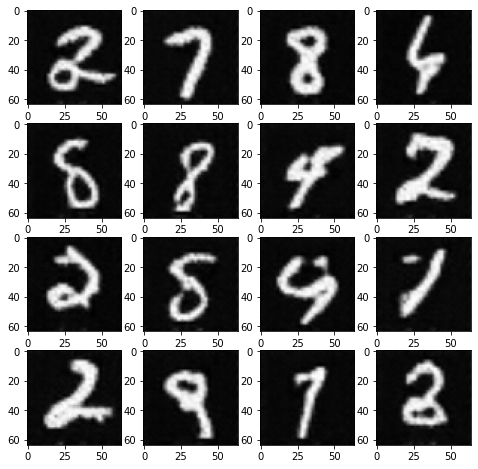

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for i in range(len(img_fake)):
    plt.subplot(4, 4, i+1)
    plt.imshow(img_fake[i], cmap="gray")
plt.show()